# 0. Imports

In [9]:
# # ideias adicionais:
#     - criar coluna gênero de quem anunciou
#     - criar coluna CEP
#     -

In [10]:
import pandas as pd
pd.set_option('display.max_columns', 1000)

# 1. Coletar dados

In [11]:
# <explicar como foi feita a coleta de dados e onde localizar .py>

| Campop               | Descrição                                      |
|----------------------|--------------------------------------------------|
| find_anuncio         | o titulo do anuncio                              |
| find_condominio      | o preço do condominio                            |
| find_descri          | a descrição feita do imovel                      |
| find_endereco        | Endereço = bairro, Cidade, estado, cep           |
| find_iptu            | IPTU                                             |
| find_loc             | geralmente a rua                                 |
| find_m_quadrado      | Tamanho do imóvel em metros quadrados            |
| find_price           | Preço do imóvel                                  |
| find_vendedor        | Informações sobre o vendedor                     |
| is_academia          | Indica se há academia/centro de fitness          |
| is_apartamento       | Indica se é um apartamento                       |
| is_ar_condicionado   | Indica se tem ar condicionado                     |
| is_churrasqueira     | Indica se há churrasqueira                       |
| is_elevador          | Indica se há elevador                            |
| is_mobiliado         | Indica se o imóvel está mobiliado                |
| is_piscina           | Indica se há piscina                             |
| is_portaria          | Indica se há portaria/serviço de portaria        |
| is_profissional      | Indica se o vendedor é um profissional           |
| is_salao_festa       | Indica se há salão de festas/área de eventos     |
| is_varanda           | Indica se há varanda                             |
| n_banheiros          | Número de banheiros                              |
| n_fotos              | Número de fotos no anúncio                       |
| n_garagens           | Número de vagas/garagens                         |
| n_quartos            | Número de quartos                                |

In [12]:
path_raw = '../scraped_data.csv'
df_raw = pd.read_csv(path_raw, sep=',', on_bad_lines='skip', nrows=100000)

In [13]:
df_raw.head(3)

,find_anuncio,find_condominio,find_descri,find_endereco,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos
0,Apartamento para venda com 105 metros quadrado...,R$ 1.100 / mês,Código do anúncio: C6BAD9\n\nO apartamento est...,"Aflitos, Recife, PE, 52050340",R$ 180,Rua da Angustura,105m²,380000,Antônio Luciano Santana da Silva,False,True,False,False,False,False,False,False,True,False,False,3,20,0,3
1,Apartamento para venda possui 51 metros quadra...,R$ 0 / mês,Código do anúncio: S623-1\n\nO apartamento no ...,"Boa Viagem, Recife, PE, 51021130",R$ 0,Rua Coronel Anízio Rodrigues Coelho,51m²,525000,Dream Residence Imóveis Recife,False,True,False,False,False,False,True,False,True,True,False,2,15,1,3
2,Apartamento para venda possui 124 metros quadr...,R$ 822 / mês,Código do anúncio: V2009TS-2225\n\nApartamento...,"Boa Viagem, Recife, PE, 51130000",R$ 291,Avenida Boa Viagem - de 6200/6201 ao fim,124m²,620000,Roberta Gadelha Batista,False,True,False,False,False,False,False,False,True,False,False,2,14,1,3


In [14]:
df_raw.shape

(75922, 24)

# 2. Realizar pré-processamento dos dados

In [15]:
df_0 = df_raw.copy()

## 2.0 <dar nome melhor para descrever essas alterações iniciais>

In [16]:
# vamos considerar como chave a coluna find_endereco(Bairro-Cidade-estado-cep), ou seja, vamos desconsiderar os imóveis com a mesma localização df_
df_0 = df_0.drop_duplicates(subset=['find_endereco'])

## 2.1 definição de tipos e criação de novas colunas derivadas

In [17]:
df_0.dtypes

find_anuncio          object
find_condominio       object
find_descri           object
find_endereco         object
find_iptu             object
find_loc              object
find_m_quadrado       object
find_price             int64
find_vendedor         object
is_academia             bool
is_apertamento          bool
is_ar_condicionado      bool
is_churrasqueira        bool
is_elevador             bool
is_mobiliado            bool
is_piscina              bool
is_portaria             bool
is_profissional         bool
is_salao_festa          bool
is_varanda              bool
n_banheiros           object
n_fotos                int64
n_garagens            object
n_quartos             object
dtype: object

In [18]:
# deixando como num a coluna find_condominio
df_0['find_condominio'] = df_0['find_condominio'].astype('str').str.replace('R$', '').str.replace(' / mês', '').str.replace('.', '')

# deixando como num a coluna find_iptu
df_0['find_iptu'] = df_0['find_iptu'].astype('str').str.replace('R$ ', '').str.replace('.', '')

# deixando como num a coluna find_m_quadrado
df_0['find_m_quadrado'] = df_0['find_m_quadrado'].astype('str').str.replace('m²', '').str.replace('.', '')

# cast direto colunas(floats devido a conseguir dar cast em NaN)
df_0['find_anuncio'] = df_0['find_anuncio'].astype('category')
df_0['find_condominio'] = df_0['find_condominio'].astype('float')
df_0['find_descri'] = df_0['find_descri'].astype('category')
df_0['find_endereco'] = df_0['find_endereco'].astype('category')
df_0['find_iptu'] = df_0['find_iptu'].astype('float')
df_0['find_loc'] = df_0['find_loc'].astype('category')
df_0['find_m_quadrado'] = df_0['find_m_quadrado'].astype('float')
df_0['find_price'] = df_0['find_price'].astype('float')
df_0['find_vendedor'] = df_0['find_vendedor'].astype('category')
df_0['is_academia'] = df_0['is_academia'].astype('category')
df_0['is_apertamento'] = df_0['is_apertamento'].astype('category')
df_0['is_ar_condicionado'] = df_0['is_ar_condicionado'].astype('category')
df_0['is_churrasqueira'] = df_0['is_churrasqueira'].astype('category')
df_0['is_elevador'] = df_0['is_elevador'].astype('category')
df_0['is_mobiliado'] = df_0['is_mobiliado'].astype('category')
df_0['is_piscina'] = df_0['is_piscina'].astype('category')
df_0['is_portaria'] = df_0['is_portaria'].astype('category')
df_0['is_profissional'] = df_0['is_profissional'].astype('category')
df_0['is_salao_festa'] = df_0['is_salao_festa'].astype('category')
df_0['is_varanda'] = df_0['is_varanda'].astype('category')
df_0['n_banheiros'] = df_0['n_banheiros'].astype('category') # motivo -> 5 ou mais
df_0['n_fotos'] = df_0['n_fotos'].astype('float')
df_0['n_garagens'] = df_0['n_garagens'].astype('category') # motivo -> 5 ou mais
df_0['n_quartos'] = df_0['n_quartos'].astype('category') # motivo -> 5 ou mais

In [19]:
df_0.dtypes

find_anuncio          category
find_condominio        float64
find_descri           category
find_endereco         category
find_iptu              float64
find_loc              category
find_m_quadrado        float64
find_price             float64
find_vendedor         category
is_academia           category
is_apertamento        category
is_ar_condicionado    category
is_churrasqueira      category
is_elevador           category
is_mobiliado          category
is_piscina            category
is_portaria           category
is_profissional       category
is_salao_festa        category
is_varanda            category
n_banheiros           category
n_fotos                float64
n_garagens            category
n_quartos             category
dtype: object

In [22]:
df_0['is_apertamento'].value_counts()

is_apertamento
True     1973
False    1356
Name: count, dtype: int64

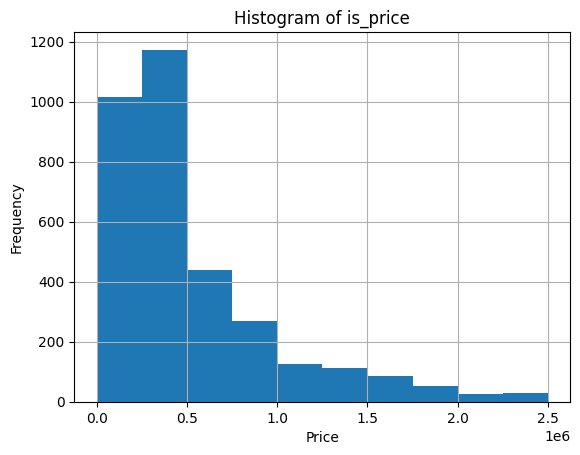

In [23]:
import matplotlib.pyplot as plt
df_0['find_price'].hist()
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of is_price')
plt.show()

## 2.2 Tratamento de dados ausentes

## 2.3 Limpeza dos dados

### 2.3.1 univariado

### 2.3.2 bivariado

### 2.3.3 multivariado

# 3. Apresentar estatísticas descritivas dos dados com visualizações

# 4. Realizar teste de hipóteses para comparação de valores de categorias e visualizar diferenças